# Tappy Keystroke Data with Parkinson’s Patients

Tappy è un'applicazione per la registrazione delle sequenze di battitura.

Nel progetto verrà analizzato un dataset contenente i registri delle sequenze di tasti raccolti da oltre 200 soggetti, con e senza il morbo di Parkinson, che hanno digitato normalmente sul proprio computer per un periodo di settimane o mesi, senza supervisione.

L'analisi si compone di una parte di acquisizione e pulizia dei dati, e di un'altra parte per l'utilizzo di modelli di machine learning, che hanno lo scopo di indicare che l'interazione con la tastiera può essere usata per rilevare particolarità nel movimento delle dita nelle prime fasi del morbo di Parkinson.

Il dataset è stato scaricato dal link https://www.kaggle.com/datasets/valkling/tappy-keystroke-data-with-parkinsons-patients. È suddiviso a sua volta in due dataset: il primo è fornito direttamente dal software Tappy, quindi include dati come tempo di pressione e rilascio dei tasti e movimenti ottenuti dividendo virtualmente la tastiera in una zona di destra e una di sinistra; il secondo contiene informazioni sui pazienti (quali anno di nascita, sesso, e attributi riguardanti il morbo di Parkinson qualora il paziente ne fosse affetto). Tra questi, l'attributo più importante è "Parkinsons", che verrà usata come predizione per la classificazione binaria.

Al dataset è associato un articolo preso dal sito https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188226#sec008, in cui viene spiegato il significato degli attributi. Da questo paper abbiamo tratto informazioni utili per l'acquisizione dei dati.

## Versione 3

## Indice

### • Caricamento dataset

### • Pulizia dataset
- Individuazione e rimozione degli outliers

### • Preprocessing
- Train e Test
- Scaling
- Bilanciamento

### • Classificazione
- Naive Bayes
- Logistic Regression
- Decision Tree 
- Random Forest
- Multiple Layer Perceptron
- Adaboost
- SVM
- K-Nearest Neighbors
- Ensemble Voting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime

### Caricamento dataset
Dopo aver creato due DataFrame a partire dai dati di Kaggle, questi vengono uniti tramite *merge* per creare un DataFrame intero, che sarà il punto di partenza del processamento dei dati.

In [2]:
# Creation of user_df, a DataFrame with informations about Archived Users

users = []

for filepath in glob.iglob('Users/Archived users/*.txt'):
    users.append(filepath[-14:-4])

user_number = len(users)    # number of users

user_df = pd.DataFrame(users, columns = ["Users"])

# Create columns

col_index = []

file = open('Users/Archived users/User_' + str(users[0]) + ".txt")
lines = file.read().split("\n")
ll = len(lines)

for l in range(ll-1):
    sl = lines[l].split(": ", 1)
    col_index.append(sl[0])

# Create values

values_list = []
values = []

for i in range(user_number):
    file = open('Users/Archived users/User_' + str(users[i]) + ".txt")
    lines = file.read().split("\n")
    for l in range(ll-1):
        sl = lines[l].split(": ", 1)
        v = sl[1]
        values.append(v)
    values_list.append(values)
    values = []

# Insert values in user_df

value_df = pd.DataFrame(values_list, columns = col_index)

user_df = pd.concat([user_df, value_df], axis = 1)

# Creation of tappydata_df, a DataFrame with informations about Archived Data

tappydata = []

for filepath in glob.iglob('Data/Tappy Data/*.txt'):
    file = open(filepath)
    lines = file.read().split("\n")
    for l in range(len(lines)-1):
        x = lines[l]
        x = x.split("\t")
        tappydata.append(x)

tappydata_df = pd.DataFrame(tappydata, columns = ["Users", "Date", "Datetime", "TapPosition", "Hold", "Movement", "Latency", "Flight", "*"])

# Merge user_df with tappydata_df, joining on the attribute "Users"

all_userdata_df = pd.merge(tappydata_df, user_df, how='inner', left_on='Users', right_on='Users')

## Pulizia dataset

Tra i pazienti con il morbo di Parkinson consideriamo solo quelli nelle prime fasi della malattia. Per questo si mantengono solo i pazienti con impatto lieve, oltre a quelli non malati.

Sempre facendo fede all'articolo di riferimento, sono stati eliminati dall'analisi anche i pazienti che assumevano Levadopa.

Inoltre sono stati rimossi i pazienti di cui sono stati analizzati troppi o troppi pochi dati, con lo scopo di avere un insieme di dati più consistente e bilanciato.

Dopo la pulizia di questi attributi, sono state cancellate le colonne ritenute meno utili per l'addestramento.

Infine si prendono in esame solo gli utenti di cui si conosce l'anno di nascita, poiché l'età è un attributo determinante e fortemente correlato alla positività al morbo di Parkinson.

In [3]:
# consider users with mild severity (if positives)
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Severe"]
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Medium"]

# consider users who do not take Levadopa
all_userdata_df = all_userdata_df[all_userdata_df.Levadopa == "False"]

counts = all_userdata_df['Users'].value_counts()
#avg = all_userdata_df.shape[0] / len(counts)
#print(avg)  # average number of taps per user

# only consider users which have >1000 and <100000 taps
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts > 1000].index)]
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts < 100000].index)]

all_userdata_df = all_userdata_df.drop(["Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)

# remove users which BirthYear is unknown
all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['BirthYear']==''].index, inplace=True)

Vengono convertiti tutti i dati, da Object a Float (Hold e Latency), Int (BirthYear)

In [ ]:
# convert and normalize

all_userdata_df.Hold = all_userdata_df.Hold.astype(float)

all_userdata_df.Latency = all_userdata_df.Latency.astype(float)

all_userdata_df.BirthYear = all_userdata_df.BirthYear.astype(int)
all_userdata_df.BirthYear = 2017 - all_userdata_df.BirthYear
all_userdata_df = all_userdata_df.rename(columns = {"BirthYear" : "Age"}) # in terms of ages

#### Istogramma per i tap e per l'età degli utenti

(array([28.,  8.,  2.,  2.,  6.,  2.,  3.,  2.,  0.,  1.]),
 array([  1000.,  10900.,  20800.,  30700.,  40600.,  50500.,  60400.,
         70300.,  80200.,  90100., 100000.]),
 <BarContainer object of 10 artists>)

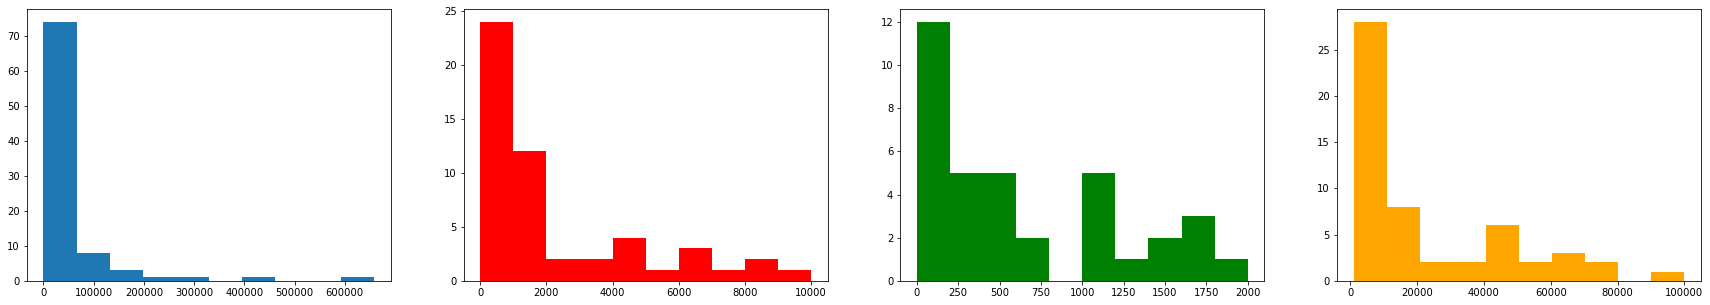

In [4]:
fig, axs = plt.subplots(1, 4, figsize = (30,5))
axs[0].hist(counts)
axs[1].hist(counts, range = [0, 10000], color = "red")
axs[2].hist(counts, range = [0, 2000], color = "green")
axs[3].hist(counts, range = [1000, 100000], color = "orange") # area of interest

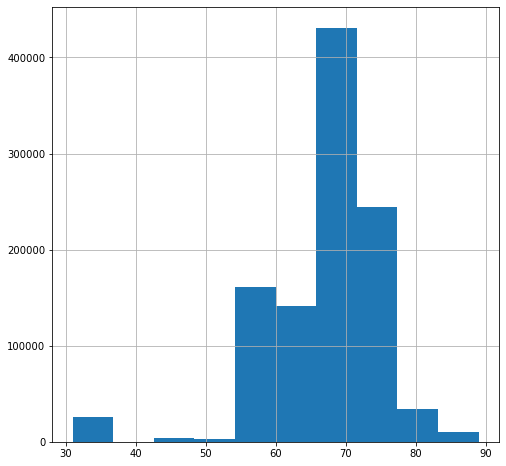

In [5]:
all_userdata_df.Age.hist(figsize=(8,8))
plt.show()

#### Individuazione e rimozione degli outliers
Ci sono valori anomali delle feature Hold e Latency. Questi vengono rimossi, mantenendo i punti che hanno un valore di deviazione standard inferiore a 3.

In [7]:
hold_z_scores = stats.zscore(all_userdata_df["Hold"])
abs_z_scores = np.abs(hold_z_scores)
filtered_entries = (abs_z_scores < 3)
all_userdata_df = all_userdata_df[filtered_entries]

lat_z_scores = stats.zscore(all_userdata_df["Latency"])
abs_z_scores = np.abs(lat_z_scores)
filtered_entries2 = (abs_z_scores < 3)
all_userdata_df = all_userdata_df[filtered_entries2]

all_userdata_df.head()

,Users,Date,Datetime,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,160916,19:20:43.891,L,78.1,LL,312.5,58,Female,False
158454,0QAZFRHQHW,160916,19:20:44.344,L,78.1,LL,453.1,58,Female,False
158455,0QAZFRHQHW,160916,19:20:44.742,L,62.5,LL,414.1,58,Female,False
158457,0QAZFRHQHW,160916,19:20:46.047,R,101.6,LR,523.4,58,Female,False
158458,0QAZFRHQHW,160916,19:20:46.242,R,93.8,RR,203.1,58,Female,False


Dopo aver convertito le feature Date e Datetime da Object a String, si crea un'unica colonna Date di tipo Datetime mettendo insieme i due vecchi attributi.

In [8]:
all_userdata_df.Date = all_userdata_df.Date.astype(str)
all_userdata_df.Datetime = all_userdata_df.Datetime.astype(str)

array_app = []

for i in range(len(all_userdata_df)):
    elem = all_userdata_df.iloc[i].Datetime[0:8]
    elem1 =all_userdata_df.iloc[i].Date
    elem_time = datetime.strptime(elem1+" " +elem, '%d%m%y %H:%M:%S')
    array_app.append(elem_time)

In [9]:
date_df = pd.DataFrame(array_app,columns=['Date'])
date_df.head()

,Date
0,2016-09-16 19:20:43
1,2016-09-16 19:20:44
2,2016-09-16 19:20:44
3,2016-09-16 19:20:46
4,2016-09-16 19:20:46


La nuova colonna Date viene di fatto sostituita alle due colonne da cui è stata derivata.

In [10]:
all_userdata_df = all_userdata_df.drop(columns=["Date","Datetime"])
all_userdata_df_v2 = pd.concat([all_userdata_df, date_df], axis=1)

all_userdata_df_v2.head(10)

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons,Date
158453,0QAZFRHQHW,L,78.1,LL,312.5,58.0,Female,False,2027-07-16 08:13:31
158454,0QAZFRHQHW,L,78.1,LL,453.1,58.0,Female,False,2027-07-16 08:13:31
158455,0QAZFRHQHW,L,62.5,LL,414.1,58.0,Female,False,2027-07-16 08:13:31
158457,0QAZFRHQHW,R,101.6,LR,523.4,58.0,Female,False,2027-07-16 08:13:31
158458,0QAZFRHQHW,R,93.8,RR,203.1,58.0,Female,False,2027-07-16 08:13:31
158459,0QAZFRHQHW,L,109.4,RL,289.1,58.0,Female,False,2027-07-16 08:13:32
158460,0QAZFRHQHW,R,214.8,LR,316.4,58.0,Female,False,2027-07-16 08:13:33
158461,0QAZFRHQHW,R,66.4,RR,382.8,58.0,Female,False,2027-07-16 08:13:33
158462,0QAZFRHQHW,L,93.8,RL,562.5,58.0,Female,False,2027-07-16 08:13:34
158463,0QAZFRHQHW,R,187.5,RR,453.1,58.0,Female,False,2027-07-16 08:13:34


Vengono codificati gli attributi Gender e Parkinsons.

In [12]:
all_userdata_df_v2.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)

all_userdata_df_v2.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)
all_userdata_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959610 entries, 158453 to 1039459
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Users        object        
 1   TapPosition  object        
 2   Hold         float64       
 3   Movement     object        
 4   Latency      float64       
 5   Age          float64       
 6   Gender       float64       
 7   Parkinsons   float64       
 8   Date         datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 149.5+ MB


# Vale scrivi

In [14]:
"""
x = complete_df.iloc[:, :-1].values
y = complete_df.iloc[:, -1].values
"""

g = len(all_userdata_df)
current_user = all_userdata_df_v2.iloc[0,0]         # start from the first position
#print(current_user)
list_users = all_userdata_df_v2.Users.unique()
len_lu =len(list_users)     # last element of list_users is NaN

data_list = []

for j in range(len_lu-1):
    #print(j)
    set = all_userdata_df_v2[all_userdata_df_v2['Users'] == list_users[j]]      # subset with rows corresponding to user j
    rif_row = set.iloc[0,:]                 # first row of the user j
    ind_row = 0                             # user j reference row index
    #print(rif_row[-1])

    for k in range(len(set)):               # scroll through rows of user j
        current_row = set.iloc[k,:]
        time2 = current_row[-1]             # date (last column) of current row
        time1 = rif_row[-1]
        diff_time = (time2 - time1).total_seconds()
        #print(diff_time)

        if(diff_time >= 90):
            # k gives the digit number in the series
            mini_df = set.iloc[ind_row:k-1,:]
            #mini_df.head()

            # estimate mean and variance of the series            
            hold_by_user =  mini_df[mini_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])
            hold_by_user_flat = hold_by_user.unstack()
            hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]
            #hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']

            latency_by_user = mini_df[np.isin(mini_df['Movement'], ['LL', 'LR', 'RL', 'RR'])].groupby(['Users', 'Movement'])['Latency'].agg([np.mean, np.std, skew, kurtosis])
            latency_by_user_flat = latency_by_user.unstack()
            latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]
            #latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
            #latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']

            combined_df = pd.concat([hold_by_user_flat, latency_by_user_flat], axis = 1)

            if (len(combined_df.values) != 0 ):
                #data_list.append(combined_df.values.tolist()[0])
                data_list.append(combined_df.reset_index(level=0).values.tolist()[0])

            # hold_by_user =  all_userdata_df[all_userdata_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])

            ind_row = k
            rif_row = set.iloc[ind_row,:]
    
print(len(data_list))

e:\Anaconda\lib\site-packages\scipy\stats\stats.py:1107: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
e:\Anaconda\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\Anaconda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
e:\Anaconda\lib\site-packages\scipy\stats\stats.py:1216: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
e:\Anaconda\lib\site-packages\scipy\stats\stats.py:1107: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
e:\Anaconda\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\Anaconda\lib\site-pac

845


# Vale scrivi

In [15]:
column_names = ['Users','mean_L','mean_R','std_L','std_R','skew_L','skew_R','kurtosis_L','kurtosis_R','mean_LL','mean_LR','mean_RL','mean_RR','std_LL','std_LR','std_RL','std_RR','skew_LL','skew_LR','skew_RL','skew_RR','kustosis_LL','kurtosis_LR','kurtosis_RL','kurtosis_RR']
#print(data_list[0:10])

stat_df = pd.DataFrame(data_list, columns = column_names)
stat_df.head(10)
#pandino.shape

stat_df = stat_df.fillna(0)
stat_df.head(10)

,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,...,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR
0,0QAZFRHQHW,89.471429,114.718182,32.242738,39.047769,-0.996278,0.894344,0.727509,0.715477,343.322222,...,114.108660,163.599360,0.008643,0.150590,1.612276,0.014354,-0.884833,-1.440186,2.778230,-1.200129
1,0QAZFRHQHW,95.710000,99.970370,22.212431,28.162920,0.318459,0.854765,-0.477679,0.866313,352.372414,...,139.543395,109.202775,-0.230768,0.206801,0.585889,0.732462,-1.123935,-1.126645,0.000542,0.165242
2,0QAZFRHQHW,85.638889,87.541026,19.892650,15.633882,0.867014,0.050560,4.767066,-0.863455,307.028000,...,110.530190,136.773129,0.889206,0.680100,0.386274,-0.005280,0.213010,-0.442493,-0.651916,-0.893680
3,0QAZFRHQHW,94.374603,99.915152,17.609913,17.646992,0.614686,1.189608,0.436707,1.890580,316.548276,...,115.772987,126.048792,0.752484,1.362838,-0.083579,0.619735,0.061265,2.039904,-1.046558,-0.421758
4,0QAZFRHQHW,100.785000,91.636364,22.656666,11.122524,0.174198,-0.786093,0.000211,-0.420832,366.712500,...,181.773109,106.455900,0.901527,1.288881,-0.244349,0.066012,-0.829680,-0.028287,-1.560858,-1.017310
5,0QAZFRHQHW,95.923684,94.400000,19.371160,24.026743,-0.552363,1.344739,1.577232,1.436836,360.160000,...,120.572572,104.493026,0.308167,0.590916,0.078188,0.515105,-1.213377,-0.580734,-1.177608,-0.074588
6,0QAZFRHQHW,102.768831,103.320690,29.878452,26.189075,-0.042985,1.186240,0.344357,2.534803,444.979412,...,149.082326,143.668950,-0.052408,-0.586051,-0.152044,0.576361,-1.069450,-0.263898,-1.573124,-0.703352
7,0QAZFRHQHW,79.660000,95.985714,6.525948,16.722782,-0.343622,0.261459,-1.153061,-1.455689,454.700000,...,0.243040,-0.665608,-0.166620,-1.550577,-1.500000,-1.100801,0.000000,0.000000,0.000000,0.000000
8,0QAZFRHQHW,103.958065,101.996000,21.975908,25.313382,0.210961,0.359783,-0.929172,-0.085760,418.872727,...,92.619828,111.834498,-0.230037,-0.844857,-0.917347,0.152074,-0.427746,-0.173139,0.266506,-1.460761
9,0QAZFRHQHW,93.170370,120.400000,25.702571,119.532802,0.538108,4.416360,0.454343,18.406848,396.395000,...,127.196429,135.702478,-0.018905,-0.292177,1.109689,0.220980,-0.502630,-1.662293,0.184948,-1.009162


In [16]:
stat_df.isna().sum()

Users          0
mean_L         0
mean_R         0
std_L          0
std_R          0
skew_L         0
skew_R         0
kurtosis_L     0
kurtosis_R     0
mean_LL        0
mean_LR        0
mean_RL        0
mean_RR        0
std_LL         0
std_LR         0
std_RL         0
std_RR         0
skew_LL        0
skew_LR        0
skew_RL        0
skew_RR        0
kustosis_LL    0
kurtosis_LR    0
kurtosis_RL    0
kurtosis_RR    0
dtype: int64

*all_userdata_df* e *stat_df* vengono uniti per creare *complete_df*, costituito da tutti i valori statistici calcolati precedentemente, a cui si aggiungono le feature Age, Gender e Parkinsons.

In [17]:
all_userdata_df = all_userdata_df.drop(["TapPosition", "Hold", "Latency", "Movement"], axis=1)
all_userdata_df = all_userdata_df.drop_duplicates()

In [18]:
# combined_df.set_index('Users', inplace = True)

# complete_df = combined_df.merge(all_userdata_df[["Users", "Age", "Gender", "Parkinsons"]], how="left", on=["Users"], indicator = True)
# combined_df.set_index('Users', inplace = True)
# all_userdata_df.set_index('Users', inplace = True)
#complete_df = pd.merge(combined_df, all_userdata_df_dropped, how='left', left_on = 'Users', right_on = 'Users')
# complete_df.shape
#complete_df.head(10)

#complete_df = combined_df.merge(all_userdata_df, how='left', left_on = 'Users', right_on = 'Users')
complete_df = stat_df.merge(all_userdata_df, how='left', left_on = 'Users', right_on = 'Users')
complete_df.head()

,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,...,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,Age,Gender,Parkinsons
0,0QAZFRHQHW,89.471429,114.718182,32.242738,39.047769,-0.996278,0.894344,0.727509,0.715477,343.322222,...,0.150590,1.612276,0.014354,-0.884833,-1.440186,2.778230,-1.200129,58,Female,False
1,0QAZFRHQHW,95.710000,99.970370,22.212431,28.162920,0.318459,0.854765,-0.477679,0.866313,352.372414,...,0.206801,0.585889,0.732462,-1.123935,-1.126645,0.000542,0.165242,58,Female,False
2,0QAZFRHQHW,85.638889,87.541026,19.892650,15.633882,0.867014,0.050560,4.767066,-0.863455,307.028000,...,0.680100,0.386274,-0.005280,0.213010,-0.442493,-0.651916,-0.893680,58,Female,False
3,0QAZFRHQHW,94.374603,99.915152,17.609913,17.646992,0.614686,1.189608,0.436707,1.890580,316.548276,...,1.362838,-0.083579,0.619735,0.061265,2.039904,-1.046558,-0.421758,58,Female,False
4,0QAZFRHQHW,100.785000,91.636364,22.656666,11.122524,0.174198,-0.786093,0.000211,-0.420832,366.712500,...,1.288881,-0.244349,0.066012,-0.829680,-0.028287,-1.560858,-1.017310,58,Female,False


#### Istogrammi per *complete_df*
Tutte le feature vengono graficate con i seguenti istogrammi.

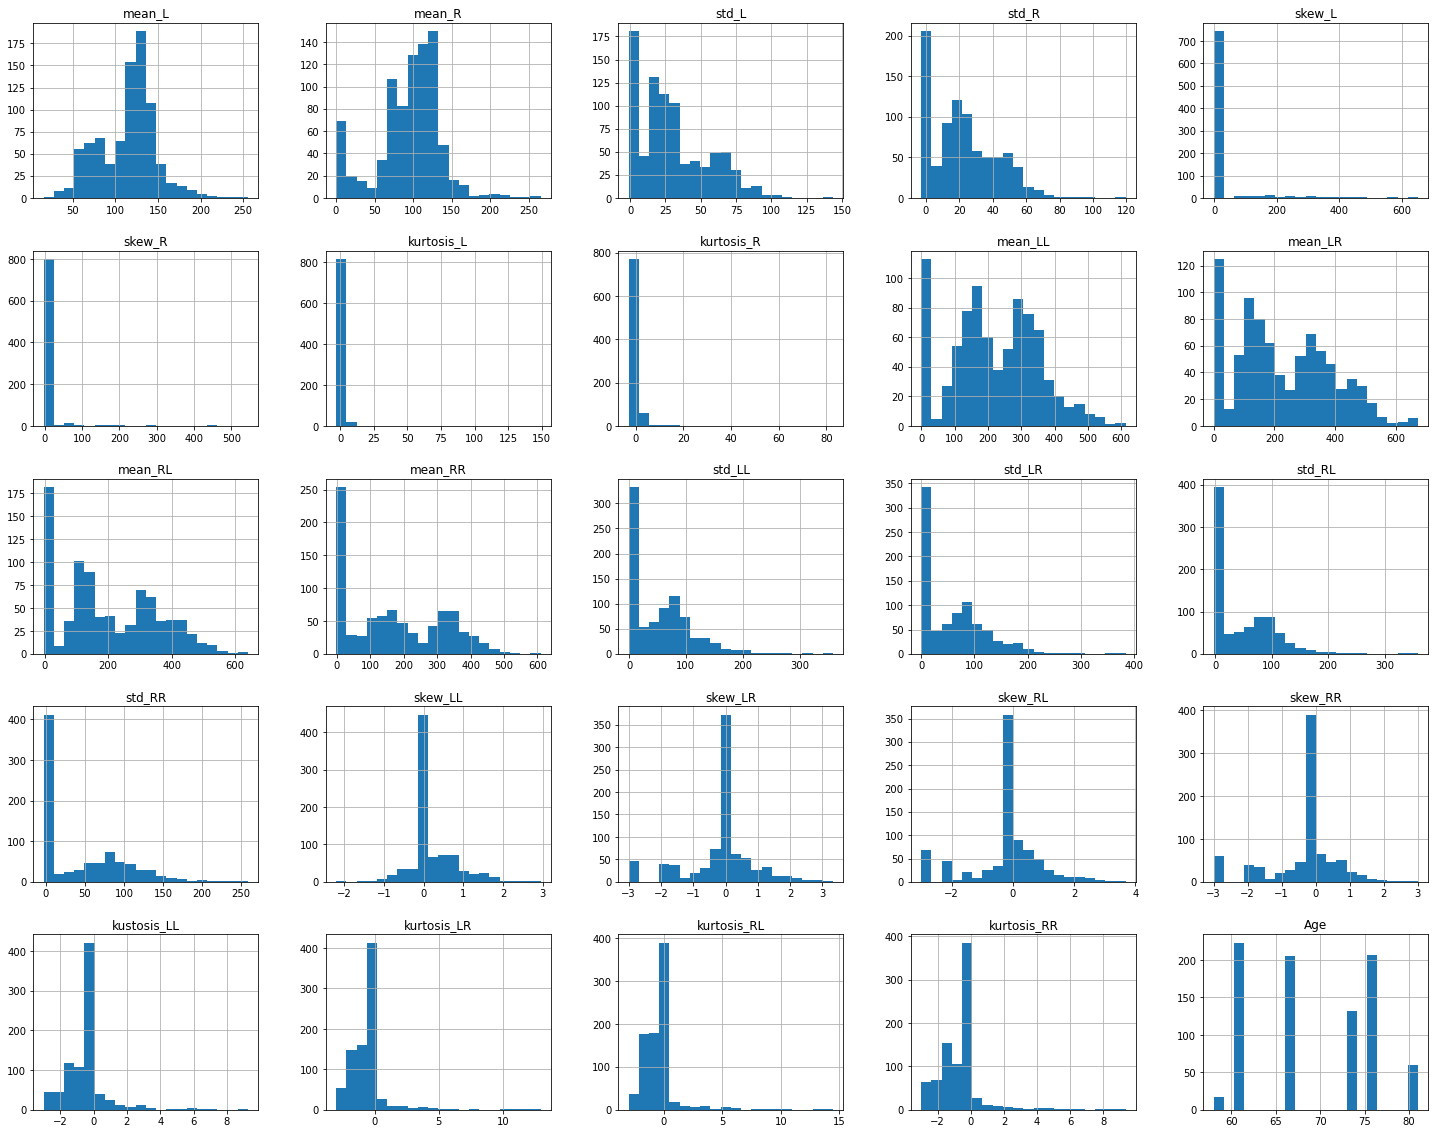

In [19]:
complete_df.hist(bins = 20, figsize=(25,20))
plt.show()

Vengono codificati gli attributi Gender e Parkinsons.

In [20]:
complete_df.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)
complete_df.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)
complete_df= complete_df.drop(['Users'],axis = 1)
complete_df.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,mean_LR,...,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,Age,Gender,Parkinsons
0,89.471429,114.718182,32.242738,39.047769,-0.996278,0.894344,0.727509,0.715477,343.322222,332.675000,...,0.150590,1.612276,0.014354,-0.884833,-1.440186,2.778230,-1.200129,58,0,0
1,95.710000,99.970370,22.212431,28.162920,0.318459,0.854765,-0.477679,0.866313,352.372414,323.521429,...,0.206801,0.585889,0.732462,-1.123935,-1.126645,0.000542,0.165242,58,0,0
2,85.638889,87.541026,19.892650,15.633882,0.867014,0.050560,4.767066,-0.863455,307.028000,294.488889,...,0.680100,0.386274,-0.005280,0.213010,-0.442493,-0.651916,-0.893680,58,0,0
3,94.374603,99.915152,17.609913,17.646992,0.614686,1.189608,0.436707,1.890580,316.548276,282.689474,...,1.362838,-0.083579,0.619735,0.061265,2.039904,-1.046558,-0.421758,58,0,0
4,100.785000,91.636364,22.656666,11.122524,0.174198,-0.786093,0.000211,-0.420832,366.712500,292.180000,...,1.288881,-0.244349,0.066012,-0.829680,-0.028287,-1.560858,-1.017310,58,0,0


Graficando i pazienti in base al valore dell'attributo Parkinsons si può notare lo sbilanciamento delle classi.

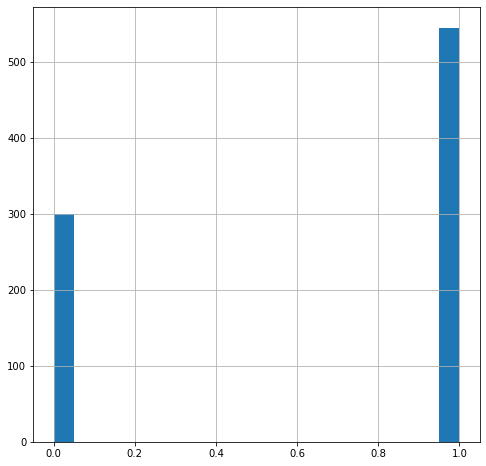

In [21]:
complete_df.Parkinsons.hist(bins=20, figsize=(8, 8))
plt.show()

Pie plot per i pazienti con e senza morbo di Parkinson.

Lo sbilanciamento è confermato dal grafico a torta.

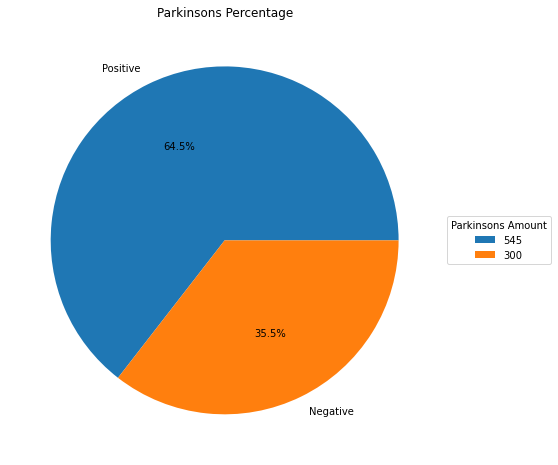

In [22]:
total_rows = complete_df.shape
counts_parkinson = complete_df[complete_df["Parkinsons"] == 1].shape

x = np.array([counts_parkinson[0], total_rows[0]-counts_parkinson[0]])
label = ["Positive", "Negative"]
plt.figure(figsize=(8,8), facecolor = "white")

plt.pie(x, labels = label, autopct='%1.1f%%')
plt.title("Parkinsons Percentage")
plt.legend(x, title="Parkinsons Amount", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [59]:

# # all_userdata_df.hist(bins = 10, figsize = (20,15), range = [0, 500])
# fig, axs = plt.subplots(1, 5, figsize = (30,5))

# axs[2].hist(all_userdata_df.Hold)
# axs[2].set_title('Hold')
# axs[3].hist(all_userdata_df.Latency)
# axs[3].set_title('Latency')
# axs[1].hist(all_userdata_df.Gender, color = "red")
# axs[1].set_title('Gender')
# axs[0].hist(all_userdata_df.Age)
# axs[0].set_title('Age')
# axs[4].hist(all_userdata_df.Parkinsons, color = "red")
# axs[4].set_title('Parkinsons')

# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==812648.4].index, inplace=True)
# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==84773.4].index, inplace=True)
# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==4480.5].index, inplace=True)

# # find = all_userdata_df[all_userdata_df.Hold > 3000]
# # print(find)
"""
complete_df.set_index('Users', inplace = True)

complete_df.head()
"""

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Age,Gender,Parkinsons
Users,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,98.931818,101.595749,23.869914,37.219557,0.236277,7.474979,0.843128,109.926842,-2.663930,406.716242,...,0.572132,-0.521971,-1.102464,-0.923822,-0.265011,-18.540793,40.979771,58,0,0
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,347.882547,...,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714,81,1,0
3DIXPRIOSW,147.626087,167.039039,47.259923,56.045862,0.665327,0.260479,0.592999,0.476607,-19.412952,528.670445,...,-0.368179,-0.096967,-1.163198,-0.854153,0.201365,74.204668,34.890816,81,1,0
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,300.190663,...,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242,67,1,1
5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739,18.325168,358.358252,...,0.611069,2.024448,-0.323100,-0.000415,0.306093,24.435956,-24.794478,74,0,1


### Preprocessing

#### Train e test
Si suddividono tutte le feature dal target, rappresentato dall'attributo Parkinsons.
Poi divido la matrice x e l'array y in sottoinsiemi casuali sfruttando la funzione *train_test_split*.

In [37]:
x = complete_df.iloc[:, :-1].values
y = complete_df.iloc[:, -1].values  # Parkinsons column

print(x)
print(y)

# split x matrix and y array in random train and test subsets, with ratio 3/4 - 1/4
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

[[ 89.47142857 114.71818182  32.24273783 ...  -1.20012881  58.
    0.        ]
 [ 95.71        99.97037037  22.21243124 ...   0.16524211  58.
    0.        ]
 [ 85.63888889  87.54102564  19.89264979 ...  -0.89368022  58.
    0.        ]
 ...
 [145.45       100.26666667  42.8587844  ...  -2.          61.
    0.        ]
 [ 93.8        125.           0.         ...   0.          61.
    0.        ]
 [146.5         46.85        63.55982559 ...   0.          61.
    0.        ]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

#### Scaling

Scalare i dati serve a migliorare il comportamento degli algoritmi di learning, dal momento che i dati potrebbero avere valori di tipi diversi tra loro. Valori troppo grandi possono comportarsi da outlier e stravolgere il funzionamento di un algoritmo.

Per scalare i dati si utilizza la normalizzazione attraverso lo *StandardScaler* offerto da sklearn.

In [25]:
# scaling before classification models
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_graph = scaler.fit_transform(x_graph)

#### Bilanciamento
Come già detto, il dataset risulta sbilanciato rispetto al target: il 62.5% delle osservazioni sono etichettate con 0 ('Negativo') mentre il 37.5% con 1 ('Positivo').

SMOTE (Synthetic Minority Oversampling Technique): serve ad aumentare la dimensione della classe minoritaria creando dati sintetici, creati in base a formule e algoritmi di clustering sui dati presenti.

In [26]:
smote = SMOTE(random_state=0, sampling_strategy='not majority', k_neighbors=5, n_jobs=-1)

x_train, y_train = smote.fit_resample(x_train, y_train)
print(x_train.shape, y_train.shape)
print(x_train)

(822, 26) (822,)
[[ 1.2338015   1.78405655  0.46280594 ... -0.74665163  1.66477099
   0.87363104]
 [-0.57804984  0.00837665 -0.40199802 ...  0.45536271 -1.73029847
  -1.14464797]
 [ 0.17053044  0.0190289   1.43552527 ... -0.67695602 -1.28746332
  -1.14464797]
 ...
 [ 0.738708   -2.19430644 -1.17699983 ...  0.51512838 -1.28746332
  -1.14464797]
 [-0.56811002 -0.40318584 -1.15089796 ...  0.51512838 -0.34685936
  -0.50160916]
 [ 0.48622756  1.8373152   0.3156476  ... -0.06391016  1.66477099
   0.87363104]]


[0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0
 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1
 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1
 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0
 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0
 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1
 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0
 1 0 1 1 0 1 0 1 0 1 1 1 

(array([411.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 411.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

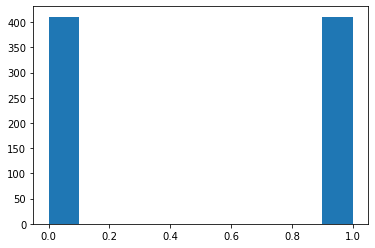

In [27]:
# verify that the classes are balanced
print(y_train)
np.histogram(y_train)
plt.hist(y_train)

### Classificazione

#### Naive Bayes

0.851581508515815
0.8679245283018868


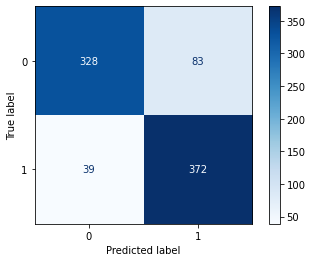

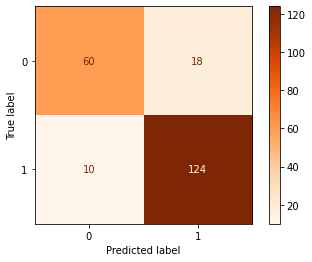

In [28]:
classifierBAYES = GaussianNB()
classifierBAYES.fit(x_train, y_train)

#The algorithm has learnt on training set, now I will predict the outcomes on test set

y_pred_BAYES0 = classifierBAYES.predict(x_train)
y_pred_BAYES = classifierBAYES.predict(x_test)

CM_BAYES0 = confusion_matrix(y_train, y_pred_BAYES0)
PercBAYES0 = (CM_BAYES0[0,0]+CM_BAYES0[1,1])/CM_BAYES0.sum()

CM_BAYES = confusion_matrix(y_test, y_pred_BAYES)
PercBAYES = (CM_BAYES[0,0]+CM_BAYES[1,1])/CM_BAYES.sum()

# each row of the confusion matrix is an instance of the true class
# matrix indicates true/false positive/negatives

cmd0 = ConfusionMatrixDisplay(CM_BAYES0)
cmd = ConfusionMatrixDisplay(CM_BAYES)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercBAYES0)
print(PercBAYES)

#### Logistic Regression

0.8917274939172749
0.9198113207547169


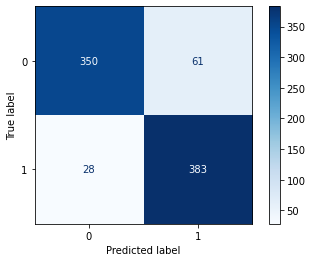

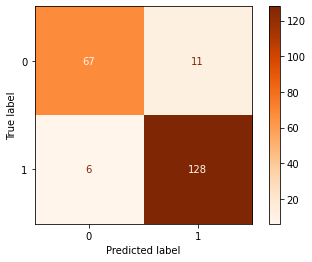

In [29]:
classifierLogReg = LogisticRegression(random_state = 0)
classifierLogReg.fit(x_train, y_train)

y_pred_LogReg0 = classifierLogReg.predict(x_train)
y_pred_LogReg = classifierLogReg.predict(x_test)

CM_LogReg0 = confusion_matrix(y_train, y_pred_LogReg0)
PercLogReg0 = (CM_LogReg0[0,0]+CM_LogReg0[1,1])/CM_LogReg0.sum()

CM_LogReg = confusion_matrix(y_test, y_pred_LogReg)
PercLogReg = (CM_LogReg[0,0]+CM_LogReg[1,1])/CM_LogReg.sum()

cmd0 = ConfusionMatrixDisplay(CM_LogReg0)
cmd = ConfusionMatrixDisplay(CM_LogReg)

cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercLogReg0)
print(PercLogReg)

#### Decision Tree

1.0
0.9952830188679245


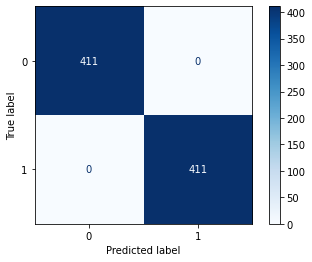

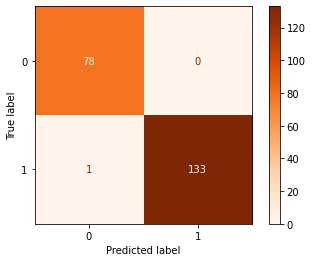

In [30]:
classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)

#### Random Forest

1.0
1.0


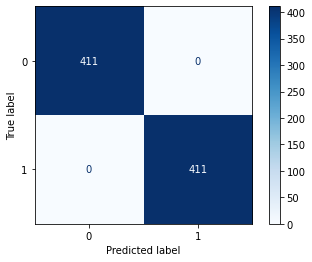

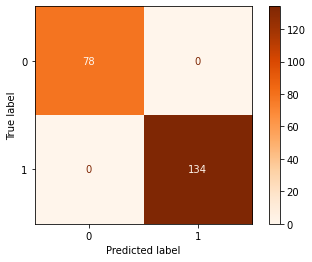

In [31]:
classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

#### Multiple Layer Perceptron

0.9416058394160584
0.9339622641509434


e:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


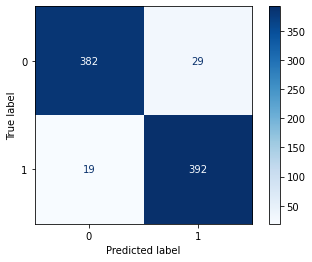

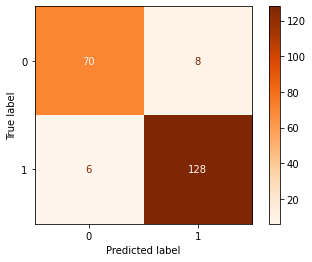

In [32]:
classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "relu", max_iter=50)         # relu act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "tanh", max_iter=50)         # tanh act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "identity", max_iter=50)     # identity act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "logistic", max_iter=50)     # logistic act

classifierMLPr.fit(x_train, y_train)

y_pred_MLPr0 = classifierMLPr.predict(x_train)
y_pred_MLPr = classifierMLPr.predict(x_test)

CM_MLPr0 = confusion_matrix(y_train, y_pred_MLPr0)
PercMLPr0 = (CM_MLPr0[0,0] + CM_MLPr0[1,1])/CM_MLPr0.sum()

CM_MLPr = confusion_matrix(y_test, y_pred_MLPr)
PercMLPr = (CM_MLPr[0,0] + CM_MLPr[1,1])/CM_MLPr.sum()

cmd0 = ConfusionMatrixDisplay(CM_MLPr0)
cmd = ConfusionMatrixDisplay(CM_MLPr)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercMLPr0)
print(PercMLPr)

#### Adaboost

In [33]:
classifierADA = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [200]
grid['learning_rate'] = [.001, .01, .1, 1]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# define the grid search procedure
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')

# execute the grid search
grid_result = grid_search.fit(x_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997571 using {'learning_rate': 1, 'n_estimators': 200}
0.946885 (0.032674) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.996356 (0.006377) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.997169 (0.006001) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.997571 (0.004859) with: {'learning_rate': 1, 'n_estimators': 200}


#### SVM

0.9951338199513382
0.9811320754716981


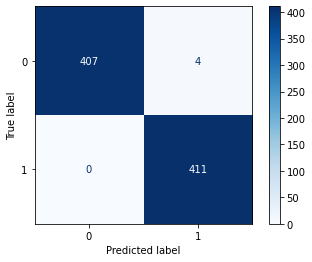

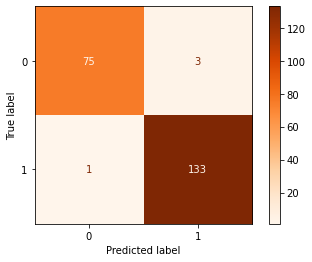

In [34]:
classifierSVC = SVC(kernel = 'rbf', random_state = 0)
classifierSVC.fit(x_train, y_train)

y_pred_SVMK0 = classifierSVC.predict(x_train)
y_pred_SVMK = classifierSVC.predict(x_test)

CM_SVMK0 = confusion_matrix(y_train, y_pred_SVMK0)
PercSVMK0 = (CM_SVMK0[0,0]+CM_SVMK0[1,1])/CM_SVMK0.sum()

CM_SVMK = confusion_matrix(y_test, y_pred_SVMK)
PercSVMK = (CM_SVMK[0,0]+CM_SVMK[1,1])/CM_SVMK.sum()

cmd0 = ConfusionMatrixDisplay(CM_SVMK0)
cmd = ConfusionMatrixDisplay(CM_SVMK)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercSVMK0)
print(PercSVMK)

#### K-Nearest Neighbors

0.9854014598540146
0.9764150943396226


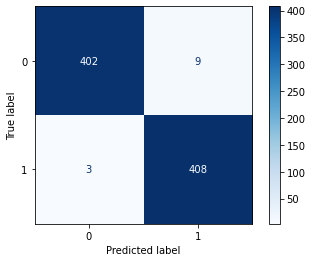

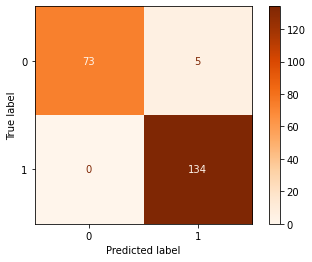

In [35]:
classifierKNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifierKNN.fit(x_train, y_train)

y_pred_KNN0 = classifierKNN.predict(x_train)
y_pred_KNN = classifierKNN.predict(x_test)

CM_KNN0 = confusion_matrix(y_train, y_pred_KNN0)
PercKNN0 = (CM_KNN0[0,0]+CM_KNN0[1,1])/CM_KNN0.sum()

CM_KNN = confusion_matrix(y_test, y_pred_KNN)
PercKNN = (CM_KNN[0,0]+CM_KNN[1,1])/CM_KNN.sum()

cmd0 = ConfusionMatrixDisplay(CM_KNN0)
cmd = ConfusionMatrixDisplay(CM_KNN)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercKNN0)
print(PercKNN)

#### Ensemble Voting

0.9987834549878345
0.9811320754716981


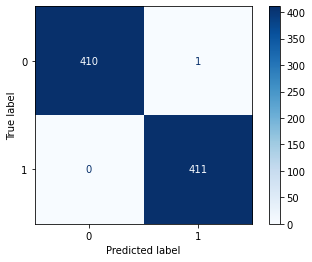

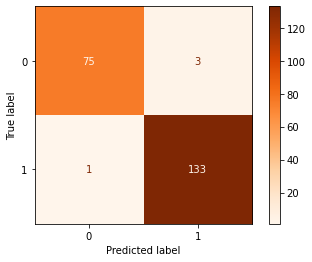

In [36]:
Models = []
Models.append(('KNN', classifierKNN))
Models.append(('SVC', classifierSVC))
Models.append(('Tree', classifierTREE))
# Models.append(('Logistic', classifierLogReg))
# Models.append(('Bayes', classifierBAYES))
# by removing these last two classifiers, performances increase

ensemble = VotingClassifier(Models)
ensemble = ensemble.fit(x_train, y_train)

y_pred_ENS0 = ensemble.predict(x_train)
y_pred_ENS = ensemble.predict(x_test)

CM_ENS0 = confusion_matrix(y_train, y_pred_ENS0)
PercENS0 = (CM_ENS0[0,0]+CM_ENS0[1,1])/CM_ENS0.sum()

CM_ENS = confusion_matrix(y_test, y_pred_ENS)
PercENS = (CM_ENS[0,0]+CM_ENS[1,1])/CM_ENS.sum()

cmd0 = ConfusionMatrixDisplay(CM_ENS0)
cmd = ConfusionMatrixDisplay(CM_ENS)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercENS0)
print(PercENS)